<a href="https://colab.research.google.com/github/itsmevidhyak/Research-Stuff/blob/master/Capital_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Capital Allocation Methodology

The objective is to understand how capital allocation works using Covariance Allocation principle and to see how the diversification credits materialise when the capital is allocated using Top-down approach.

In [1]:
# Import packages
import collections
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import seaborn as sns
import numpy as np
import pandas as pd

# For this notebook keep the version at tf 1.15.0
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

print(tf.__version__)
print(tfp.__version__)
tf.executing_eagerly()


1.15.0
0.7.0


True

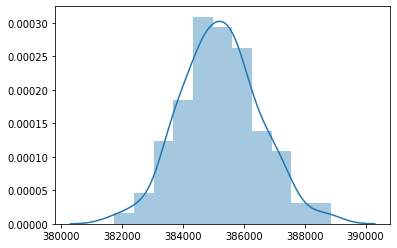

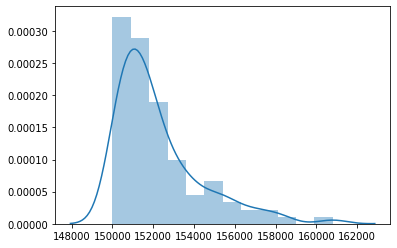

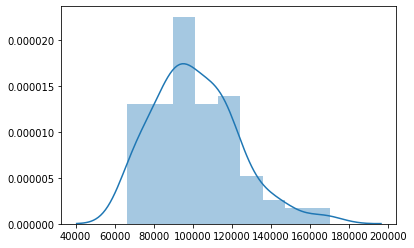

In [2]:
# Simulate losses from 3 sub portfolios
lob1, lob2, lob3 = [ tfd.Gamma(concentration = 77000, rate = 1.0/5.0),
                     tfd.Pareto(concentration = 70.0, scale = 150000),
                     tfd.LogNormal(loc = 11.5, scale = 0.19804)]
# Draw samples and plot them
sns.distplot(lob1.sample(100).numpy().ravel())
plt.show()
sns.distplot(lob2.sample(100).numpy().ravel())
plt.show()
sns.distplot(lob3.sample(100).numpy().ravel())
plt.show()

In [3]:
# Judge whether the lob samples are in the range as wanted
lob3.sample(10).numpy().ravel()

array([ 97408.85 ,  97548.67 ,  78797.77 ,  83278.484, 108771.836,
       104973.516,  76910.2  ,  96606.58 ,  80550.414, 108691.06 ],
      dtype=float32)

In [4]:
# Combine all losses from all lobs to a single dataframe
Loss_on_Lob1 = pd.DataFrame(lob1.sample(100).numpy().ravel())
Loss_on_Lob2 = pd.DataFrame(lob2.sample(100).numpy().ravel())
Loss_on_Lob3 = pd.DataFrame(lob3.sample(100).numpy().ravel())
All_Loss = pd.concat([Loss_on_Lob1, Loss_on_Lob2, Loss_on_Lob3], axis = 1)
names = ['EL', 'MA', 'PI']
All_Loss.columns = names
All_Loss

,EL,MA,PI
0,384013.75000,153038.390625,97879.859375
1,384518.71875,150148.656250,82963.070312
2,383509.43750,151817.312500,129633.757812
3,384429.37500,153800.531250,107700.812500
4,387523.12500,153586.968750,97715.515625
...,...,...,...
95,382703.12500,150208.093750,79885.992188
96,386532.87500,150386.546875,113582.265625
97,386279.53125,151046.140625,91755.851562
98,382946.40625,153893.406250,63564.332031


696072.8790624999

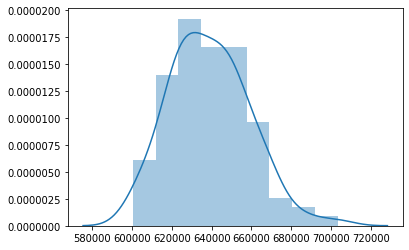

In [5]:
# Calculate Aggregate Capital
Aggregate_Losses = All_Loss.sum(axis = 1)
sns.distplot(Aggregate_Losses)

# Assuming I am going to set aside a capital at 99.5th percentile of losses
Aggregate_Capital = np.quantile(Aggregate_Losses, 0.995)
Aggregate_Capital

In [6]:
# Check how much capital we will receive if we allocate without diversification
Capital_1 = np.quantile(Loss_on_Lob1, 0.995)
Capital_2 = np.quantile(Loss_on_Lob2, 0.995)
Capital_3 = np.quantile(Loss_on_Lob3, 0.995)
k = [Capital_1, Capital_2, Capital_3]
k
np.sum(k)

705888.4819531249

## Model

We will use Covariance allocation principle. Let us assume the purpose of the allocation exercise is to rank the business units according to levels
of profitability.

Reference: https://www.researchgate.net/publication/24046637_Optimal_capital_allocation_principles

Let $S$ be the aggregate loss in a portfolio of $n$ individual losses $X_1, X_2, ..., X_n$ expected to materialise at a future time horizon, say time $T$. Assume $X_i$ be the loss faced by the business unit $i$.

Let Aggregate Loss be, 

$$ S =  \Sigma_{i = 1}^{n} X_i$$

Let the Aggregate Capital determined by the company be,

$$ K =  \Sigma_{i = 1}^{n} K_i$$

where $K_i$ is the capital to be allocated to $i^{th}$ loss. $K$ is termed as full allocation requirement. 

By virtue of covariance allocation principle by Overbeck (2000), 

$$K_i = \frac {K} {Var[S]} . Cov (X_i, S), \ \ \ \ i = 1, 2, ..., n $$

where $Cov (X_i, S) $ is the covariance between the individual loss $X_i$ and the aggregate loss $S$ and $Var[S] $ is the variance of the aggregate loss $S$.

Because the sum of these individual covariances is equal to the variance of the aggregate loss, the full allocation requirement is automatically satisfied in this case.

One important advantage of the covariance allocation principle is that, it explicitly takes into account the dependence structure of the random losses $X_1 ,X_2 ,...,X_n $. Business units with a loss that is more correlated with the aggregate portfolio loss $S$ are penalised by requiring them to hold a larger amount of capital than those which are less correlated.

In [24]:
# Implementation of the model

K = Aggregate_Capital
Loss = np.matrix(All_Loss)
S = np.matrix(Aggregate_Losses)

def mean(x):
    return sum(x) / len(x)

def cov(x, y):
    x_mean = mean(x)
    y_mean = mean(y)
    data = [(x[i] - x_mean) * (y[i] - y_mean)
            for i in range(len(x))]
    return sum(data) / (len(data) - 1)

cov1 = cov(Loss[:,0], S.T)
cov2 = cov(Loss[:,1], S.T)
cov3 = cov(Loss[:,2], S.T)

Total_cov = np.concatenate((cov1, cov2, cov3))

K_i = (K / np.var(S)) * Total_cov
K_i

# Sense check whether there is a diversification benefit materialised from the capital allocation
if np.sum(K_i) < np.sum(k): print(np.sum(k) - np.sum(K_i))

2784.231953124865


In [25]:
K_i

matrix([[ 10478.369],
        [  2456.758],
        [690169.1  ]], dtype=float32)

In [28]:
# Remember our purpose is to rank the Lobs based on the level of profitability
K_i = sorted(K_i)

# Order of LOBs from highest to lowest of the capital
from tabulate import tabulate
print(tabulate([['MA', int(K_i[0]), 1], ['EL', int(K_i[1]), 2], ['PI', int(K_i[2]), 3]], headers=['Line of Business', 'Capital Allocated', 'Rank']))

Line of Business      Capital Allocated    Rank
------------------  -------------------  ------
MA                                 2456       1
EL                                10478       2
PI                               690169       3


## Conclusion

As we can see above, had we analysed the losses separately for the three portfolios, we would have set aside a capital of 709087 units at 99.5th percentile level. When the top-down approach using Covariance allocation principle is used, we experienced a diversification benefit of 6618 units. 

Note: The figures mentioned in the conclusion is subject to change when the run time is restarted and rerunning happens.